In [6]:
import h5py
import numpy as np

data = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns3287_5000-5050_dx2_sm3_snr300_p100_k0p1_phi0.npz",
    allow_pickle=True,
)

data["weights_fid"]

array([[89717.18 , 89566.1  , 89383.42 , ..., 99399.38 , 98423.8  ,
        97905.67 ],
       [89718.56 , 89567.375, 89384.54 , ..., 99402.97 , 98427.64 ,
        97909.71 ],
       [89720.734, 89569.46 , 89386.516, ..., 99405.01 , 98430.14 ,
        97912.52 ],
       ...,
       [89709.586, 89558.914, 89376.64 , ..., 99357.62 , 98381.414,
        97862.5  ],
       [89708.875, 89558.37 , 89376.31 , ..., 99343.43 , 98368.086,
        97849.52 ],
       [89708.195, 89557.83 , 89375.97 , ..., 99341.05 , 98366.46 ,
        97848.305]], dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.ccf import get_full_ccf_analysis

raw_dset = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns3287_5000-5050_dx2_sm3_snr300_p100_k0p1_phi0.npz",
    allow_pickle=True,
)

print(raw_dset.files)

wavegrid = raw_dset["wavegrid"]
template = raw_dset["template"]
spectra = raw_dset["spectra"]
activity = raw_dset["activity"]
time_values = raw_dset["time_values"]
v_true = raw_dset["v_true"]
metadata = raw_dset["metadata"].item()
spectra_no_activity = raw_dset["spectra_no_activity"]

ccf_data = np.load(
    "/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/ccf_results/ccf_analysis_results.npz",
    allow_pickle=True
)

print(ccf_data.files)

all_rvs_ccf = ccf_data["rvs"]
all_time_values = ccf_data["time_values"]
random_ccf = ccf_data["raw_ccfs"][np.random.randint(0, ccf_data["raw_ccfs"].shape[0])]
v_grid_ccf = ccf_data["v_grid"]
ccf_params = ccf_data["metadata"].item()

full_ccf_analysis = get_full_ccf_analysis(
    spectra=spectra,
    wavegrid=wavegrid,
    v_grid=v_grid_ccf,
    window_size_velocity=ccf_params["window_size_velocity"],
)

v_apparent = full_ccf_analysis["rv"]

full_ccf_analysis_amp_x5 = get_full_ccf_analysis(
    spectra=raw_dset_amp_x5["spectra"],
    wavegrid=raw_dset_amp_x5["wavegrid"],
    v_grid=v_grid_ccf,
    window_size_velocity=ccf_params["window_size_velocity"],
)

v_apparent_amp_x5 = full_ccf_analysis_amp_x5["rv"]

/home/tliopis/Codes/exoplanets_llopis_mary_2025/venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: '/home/tliopis/Codes/exoplanets_llopis_mary_2025/data/npz_datasets/soapgpu_ns1000_5000-5050_dx2_sm3_p100_k0p1_phi0.npz'

In [5]:
wavegrid.min()

5000.00520002349

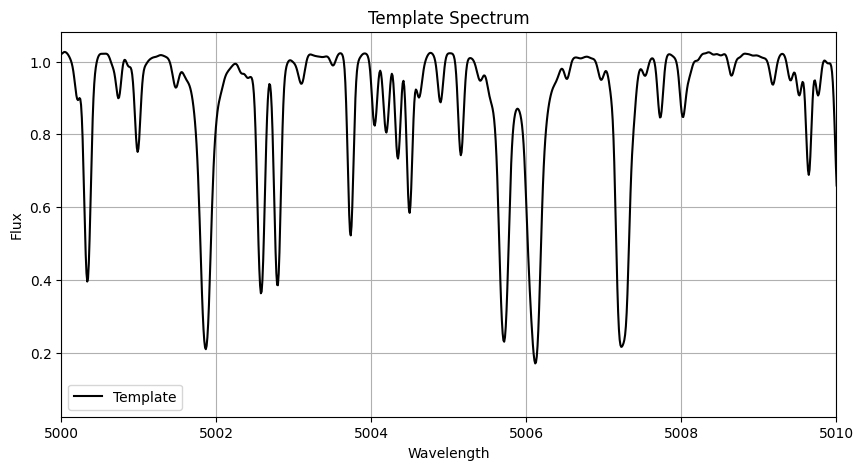

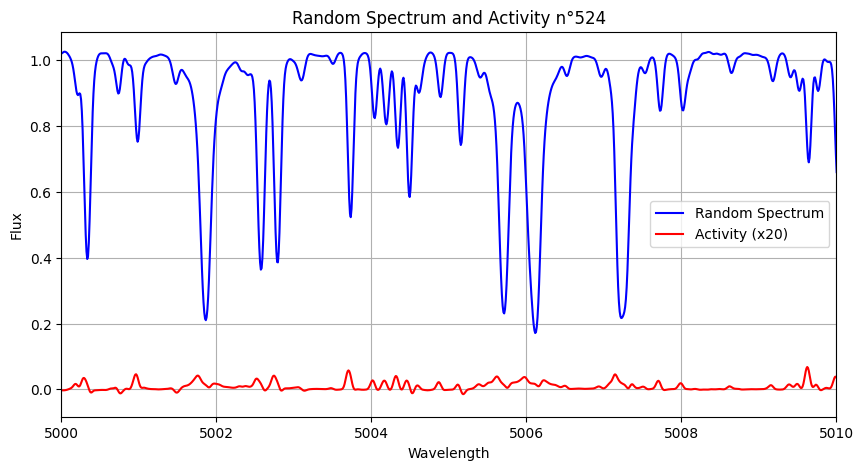

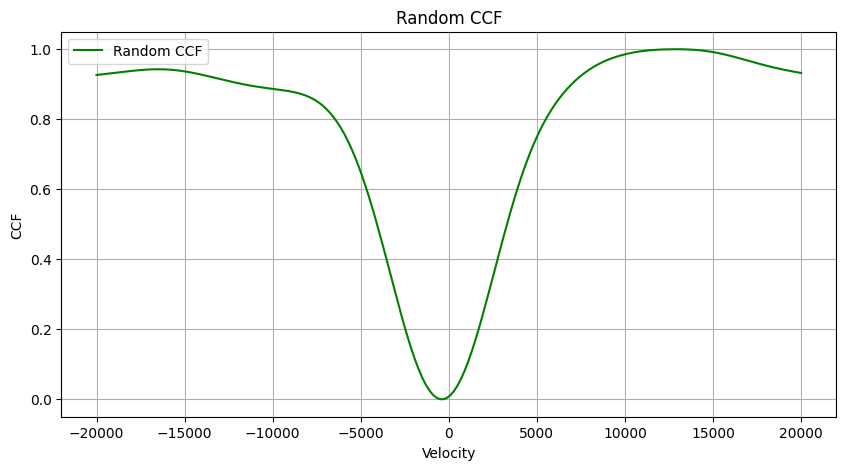

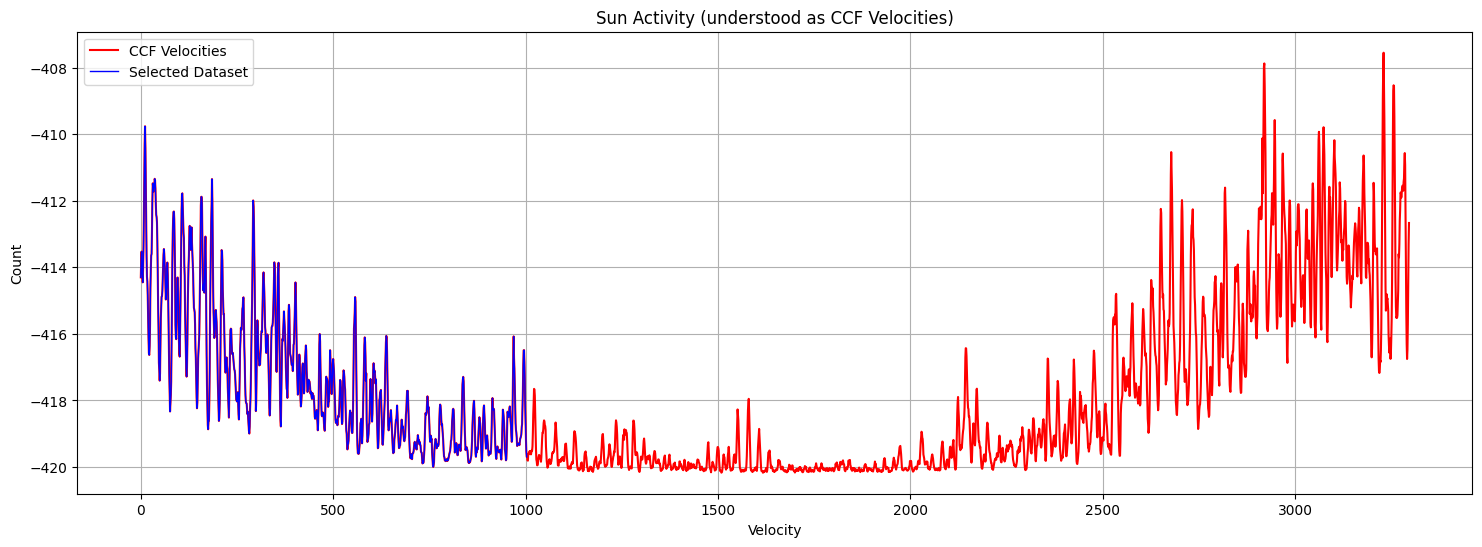

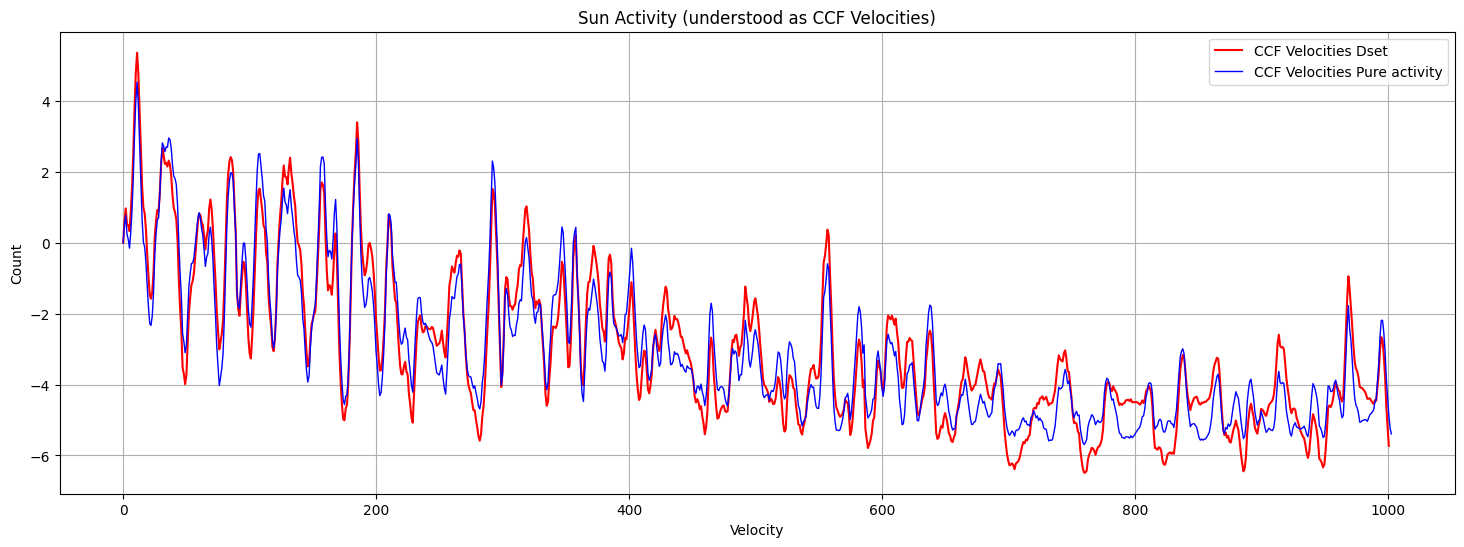

In [47]:
xlim = (5000, 5010)
# Plot du template

plt.figure(figsize=(10, 5))
plt.plot(wavegrid, template, color="k", label="Template")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title("Template Spectrum")
plt.xlim(xlim)
plt.legend()
plt.show()

# Plot d'un spectre random et de son activity (x 20)

random_index = np.random.randint(0, spectra.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(wavegrid, spectra[random_index], color="b", label="Random Spectrum")
plt.plot(wavegrid, 50 * activity[random_index], color="r", label="Activity (x20)")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.grid()
plt.title(f"Random Spectrum and Activity n°{random_index}")
plt.legend()
plt.xlim(xlim)
plt.show()

# Plot d'une ccf random
plt.figure(figsize=(10, 5))
plt.plot(v_grid_ccf, random_ccf, color="g", label="Random CCF")
plt.xlabel("Velocity")
plt.ylabel("CCF")
plt.grid()
plt.title(f"Random CCF")
plt.legend()
plt.show()

# Plot des vitesses obtenues par ccf sur tout le dset
plt.figure(figsize=(18, 6))
plt.plot(all_time_values, all_rvs_ccf, color="red", label="CCF Velocities")
plt.plot(all_time_values[time_values], all_rvs_ccf[time_values], color="blue", linewidth=1,label="Selected Dataset")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.grid()
plt.title(f"Sun Activity (understood as CCF Velocities)")    
plt.legend()
plt.show()

# Vitesses obtenues par ccf sur le dataset (avec planète injectée)

plt.figure(figsize=(18, 6))
plt.plot(time_values, v_apparent - v_apparent[0], color="red", label="CCF Velocities Dset")
plt.plot(
    all_time_values[time_values],
    all_rvs_ccf[time_values] - all_rvs_ccf[time_values][0],
    color="blue",
    linewidth=1,
    label="CCF Velocities Pure activity",
)
# plt.plot(
#     time_values,
#     v_apparent_amp_x5 - v_apparent_amp_x5[0],
#     color="orange",
#     linewidth=1,
#     label="CCF Velocities Dset (Amp x5)",
# )
# plt.plot(time_values, v_true, color="green", label="True Velocities")
plt.xlabel("Velocity")
plt.ylabel("Count")
plt.grid()
plt.title(f"Sun Activity (understood as CCF Velocities)")    
plt.legend()
plt.show()

In [7]:
len(all_time_values)

3292